In [375]:
import jax.numpy as jnp 
from jax import grad 
import numpy as np 
import pandas as pd 
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt 
datapath = "./"

In [376]:
def model(x, w): 
	"""
	input: 
	- x: shape (N, P)  
	- W: shape (N+1, C) 

	output: 
	- prediction: shape (C, P) 
	"""
	# option 1: stack 1 
	f = x   
	# print("before stack 1, x.shape: ", f.shape)

	# tack a 1 onto the top of each input point all at once
	o = jnp.ones((1, np.shape(f)[1]))
	f = jnp.vstack((o,f))

	# print("after stack 1, the X.shape:", f.shape)

	# compute linear combination and return
	a = jnp.dot(f.T,w)

	# option 2: 
	# a = w[0, :] + jnp.dot(x.T, w[1:, :])
	return a.T


In [3]:
# multi-class softmax cost function 
def multiclass_softmax(w, x_p, y_p):     
	"""
	Args:
	 	- w: parameters. shape (N+1, C), C= the number of classes
	 	- x_p: input. shape (N, P) 
		- y_p: label. shape (1, P)
	Return: 
		- softmax cost: shape (1,)
	"""
    
	# pre-compute predictions on all points
	all_evals = model(x_p,w)
	# print(f"all_evals[:, 0:5].T={all_evals[:, 0:5].T}")

	# logsumexp trick
	maxes = jnp.max(all_evals, axis=0)
	a = maxes + jnp.log(jnp.sum(jnp.exp(all_evals - maxes), axis=0))

	# compute cost in compact form using numpy broadcasting
	b = all_evals[y_p.astype(int).flatten(), jnp.arange(np.size(y_p))]
	cost = jnp.sum(a - b)

	# return average
	return cost/float(np.size(y_p))

In [4]:
def run_task1(): 

	# import MNIST
	x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

	# re-shape input/output data
	x = x.T
	y = np.array([int(v) for v in y])[np.newaxis,:]

	print(np.shape(x)) # (784, 70000)
	print(np.shape(y)) # (1, 70000)

	# TODO: fill in your code 

In [377]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# re-shape input/output data
x = x.T
y = np.array([int(v) for v in y])[np.newaxis,:]

print(np.shape(x)) # (784, 70000)
print(np.shape(y)) # (1, 70000)

/home/jianhuang/miniconda3/envs/biosim/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(784, 70000)
(1, 70000)


In [398]:
def gradient_descent(cost_func, x, y, alpha=1e-2, iterations=500):
    gradient = grad(cost_func, argnums=0)

    # w = np.array([3.,3.])
    w_dim = (x.shape[0]+1, np.unique(y).size)
    w = np.random.rand(w_dim[0], w_dim[1])*0.005
    cost = cost_func(w, x, y)
    w_history = [w, ]
    cost_history = [cost, ]
    grad_history = [gradient(w, x, y), ]
    for i in np.arange(1, iterations, 1):
        # get gradient
        w_grad = gradient(w, x, y)
        grad_history.append(w_grad)

        w = w - alpha * w_grad
        w_history.append(w)

        # cost
        cost = cost_func(w, x, y)
        cost_history.append(cost)

    return w_history, cost_history

In [6]:
jnp.array(x.loc[:,:50])

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [379]:
x_training = jnp.array(x.iloc[:,:50000])
y_training = jnp.array(y[:,:50000])

In [50]:
w_history, cost_history = gradient_descent(multiclass_softmax, x_training, y_training, alpha=np.float_power(10, -3), iterations=100)

In [43]:
def get_accuracy(w, x, y):
	x_append_transpose = jnp.vstack([jnp.ones(x.shape[1]), x]).T
	pred_values = jnp.dot(x_append_transpose, w)
	pred_y = pred_values.argmax(axis=1)
	# print(pred_y)
	miscalssfications = jnp.count_nonzero(pred_y - y)
	# print("miscalssfications", miscalssfications)
	acc = (y.size - miscalssfications) / y.size
	# print("accuracy: %.1f %%" % (acc*100))
	return acc

In [187]:
def get_optimal_gamma(cost_func, x, y, gamma_arr=np.arange(-2, 7, 1), iterations=10):
    results = []
    for a in gamma_arr:
        w_history, cost_history = gradient_descent(cost_func, x, y, alpha=np.float_power(10, -1*a), iterations=iterations)
        # print("cost_history", cost_history)
        acc_tmp = []
        for w in w_history:
            acc = get_accuracy(w, x, y)
            acc_tmp.append(acc)
        results.append((a, cost_history, acc_tmp))
        
    min_idx = int(jnp.argmin(jnp.array([i[1][-1] for i in results])))
    return results[min_idx]

# Original dataset

In [399]:
results_original = get_optimal_gamma(multiclass_softmax, x_training, y_training, gamma_arr=np.arange(-2, 7, 1), iterations=10)

In [382]:
print(results_original)

(4, [DeviceArray(109.44438, dtype=float32), DeviceArray(79.36343, dtype=float32), DeviceArray(62.72122, dtype=float32), DeviceArray(53.46217, dtype=float32), DeviceArray(47.06505, dtype=float32), DeviceArray(42.131393, dtype=float32), DeviceArray(38.12479, dtype=float32), DeviceArray(34.808403, dtype=float32), DeviceArray(32.05712, dtype=float32), DeviceArray(29.735558, dtype=float32)], [DeviceArray(0.05846, dtype=float32), DeviceArray(0.10664, dtype=float32), DeviceArray(0.14126, dtype=float32), DeviceArray(0.17768, dtype=float32), DeviceArray(0.21592, dtype=float32), DeviceArray(0.25324, dtype=float32), DeviceArray(0.28936, dtype=float32), DeviceArray(0.32416, dtype=float32), DeviceArray(0.35494, dtype=float32), DeviceArray(0.38102, dtype=float32)])


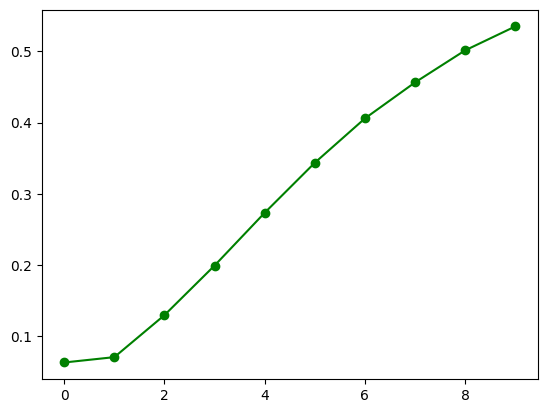

In [400]:
plt.plot(results_original[-1], "go-")

# Standarized Normalization

In [217]:
def standard_normalization(x):
    """
    x: input N; (dimensions) * P (samples)
    return: standardized_x; N (dimensions) * P (samples)
    """
    standardized_x = ( ( x.T - x.mean(axis=1) ) / x.std(axis=1) ).T
    standardized_x = jnp.nan_to_num(standardized_x, nan=0)
    return standardized_x

In [218]:
x_standardized = standard_normalization(x_training)

In [219]:
results_standard = get_optimal_gamma(multiclass_softmax, x_standardized, y_training, gamma_arr=np.arange(-2, 7, 1), iterations=10)

In [220]:
print(results_standard)

(0, [DeviceArray(11.107332, dtype=float32), DeviceArray(4.4036393, dtype=float32), DeviceArray(2.7481375, dtype=float32), DeviceArray(2.1588275, dtype=float32), DeviceArray(1.8507932, dtype=float32), DeviceArray(1.655005, dtype=float32), DeviceArray(1.5160704, dtype=float32), DeviceArray(1.4106088, dtype=float32), DeviceArray(1.327176, dtype=float32), DeviceArray(1.2591288, dtype=float32)], [DeviceArray(0.0873, dtype=float32), DeviceArray(0.47968, dtype=float32), DeviceArray(0.6084, dtype=float32), DeviceArray(0.67356, dtype=float32), DeviceArray(0.71294, dtype=float32), DeviceArray(0.7398, dtype=float32), DeviceArray(0.75806, dtype=float32), DeviceArray(0.77334, dtype=float32), DeviceArray(0.78534, dtype=float32), DeviceArray(0.79428, dtype=float32)])


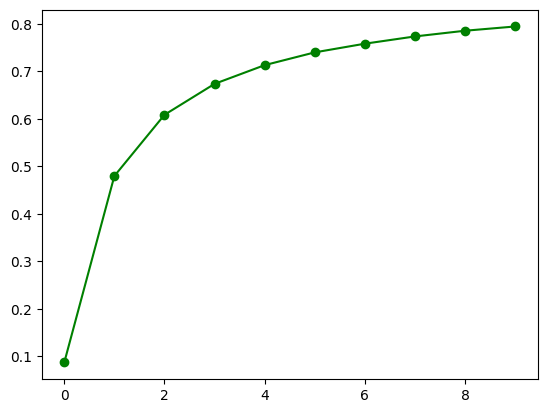

In [221]:
plt.plot(results_standard[-1], "go-")

# PCA sphering

In [210]:
def center(x):
    standardized_x = (x.T - x.mean(axis=1)).T
    return standardized_x

def compute_pcs(x, lam):
    p = float(x.shape[1])
    cov = 1/p * np.dot(x, x.T) + lam*np.eye(x.shape[0]) # adding lam to prevent numerical stability
    D, V = np.linalg.eigh(cov)
    return D, V

def pca_transform_data(x, **kwargs):
    num_components = x.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs["num_components"]
    lam = 1e-7
    if "lam" in kwargs:
        lam = kwargs["lam"]
    
    D, V = compute_pcs(x, lam)
    V = V[:, -num_components:]
    D = D[-num_components:]
    
    # compute transformed data for PC space
    w = np.dot(V.T, x)
    return w, V

In [197]:
x_center = center(x_training)
kwargs = {'lam':1e-7}
x_pca, V = pca_transform_data(x_center, **kwargs)
x_pac_scale = ( x_pca.T  / x_pca.std(axis=1) ).T
x_pac_scale = jnp.nan_to_num(x_pac_scale, nan=0)

/tmp/ipykernel_99/2966652489.py:4: RuntimeWarning: invalid value encountered in true_divide
  x_pac_scale = ( x_pca.T  / x_pca.std(axis=1) ).T


In [198]:
results_pca = get_optimal_gamma(multiclass_softmax, x_pac_scale, y_training, gamma_arr=np.arange(-2, 7, 1), iterations=10)

In [199]:
print(results_pca)

(-1, [DeviceArray(11.220537, dtype=float32), DeviceArray(4.4452415, dtype=float32), DeviceArray(1.9346999, dtype=float32), DeviceArray(1.1847867, dtype=float32), DeviceArray(0.86632013, dtype=float32), DeviceArray(0.69248724, dtype=float32), DeviceArray(0.5803515, dtype=float32), DeviceArray(0.50780994, dtype=float32), DeviceArray(0.4581514, dtype=float32), DeviceArray(0.4307542, dtype=float32)], [DeviceArray(0.08646, dtype=float32), DeviceArray(0.40414, dtype=float32), DeviceArray(0.6819, dtype=float32), DeviceArray(0.7829, dtype=float32), DeviceArray(0.82912, dtype=float32), DeviceArray(0.85458, dtype=float32), DeviceArray(0.87248, dtype=float32), DeviceArray(0.88472, dtype=float32), DeviceArray(0.89326, dtype=float32), DeviceArray(0.89856, dtype=float32)])


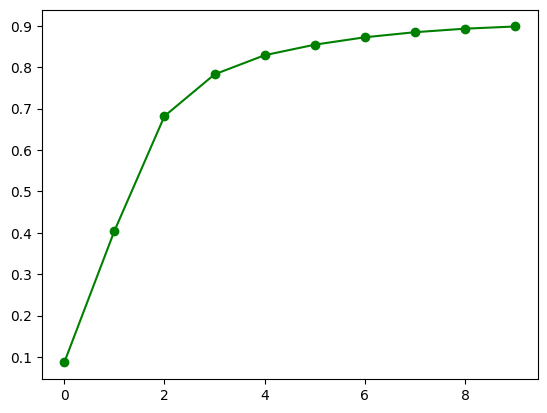

In [200]:
plt.plot(results_pca[-1], "go-")

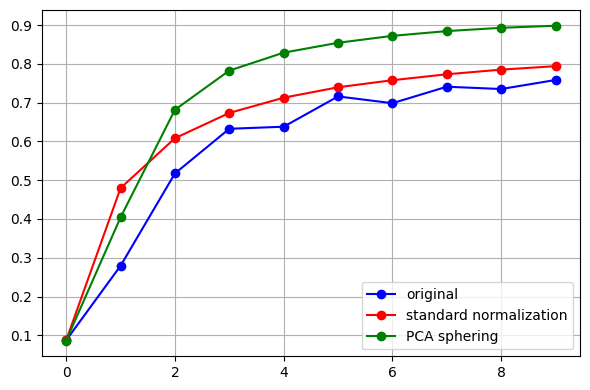

In [393]:
# plot together
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(results_original[-1], "bo-", label="original")
ax.plot(results_standard[-1], "ro-", label="standard normalization")
ax.plot(results_pca[-1], "go-", label="PCA sphering")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

**The traing using the original data seems a little too low (consistently lower) than the sample figure in the rubic**

# Task2

In [223]:
csvname =  datapath + 'boston_housing.csv'
data = np.loadtxt(csvname, delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

print(np.shape(x))
print(np.shape(y))

(13, 506)
(1, 506)


In [227]:
# standard normalization
x_standard = standard_normalization(x)
y_standard = standard_normalization(y)

In [228]:
x_standard.shape

(13, 506)

In [229]:
y_standard.shape

(1, 506)

In [235]:
jnp.abs(np.random.rand(13, 1)).shape

(13, 1)

In [239]:
x.shape[0]+1

14

In [355]:
def model(x, w): 
    """
    input: 
    - x: shape (N, P)  
    - W: shape (N+1, C) 

    output: 
    - prediction: shape (C, P) 
    """
    # option 1: stack 1 
    f = x   
    # print("before stack 1, x.shape: ", f.shape)

    # tack a 1 onto the top of each input point all at once
    o = jnp.ones((1, np.shape(f)[1]))
    f = jnp.vstack((o,f))

    # print("after stack 1, the X.shape:", f.shape)

    # compute linear combination and return
    a = jnp.dot(f.T,w)

    # option 2: 
    # a = w[0, :] + jnp.dot(x.T, w[1:, :])
    return a.T

def gradient_descent_linear(cost_func, x, y, lamb, alpha=1e-2, iterations=500):
    gradient = grad(cost_func, argnums=0)

    # w = np.array([3.,3.])
    w_dim = (x.shape[0]+1, 1)
    w = np.random.rand(w_dim[0], w_dim[1])
    cost = cost_func(w, x, y, lamb)
    w_history = [w, ]
    cost_history = [cost, ]
    # grad_history = [gradient(w, x, y, lamb), ]
    beta = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    grad_history = [gradient(w, x, y, lamb), ]
    momentum_history = [np.zeros(w_dim), ]
    secondary_list = [np.zeros(w_dim), ]
    
    for i in np.arange(1, iterations, 1):
        # get gradient
        w_grad = gradient(w, x, y, lamb)
        grad_history.append(w_grad)

        # get momentum
        momentum = (1 - beta) * w_grad + beta * momentum_history[-1]
        momentum_history.append(momentum)

        # second derivative estimate
        w_grad_square = w_grad ** 2
        secondary = beta_2 * secondary_list[-1] + (1 - beta_2) * w_grad_square
        secondary_list.append(secondary)

        # momentum with normalization <-- adam
        w = w - ((alpha * momentum / (1 - jnp.power(beta, i))) / (
                jnp.sqrt(secondary / (1 - jnp.power(beta_2, i))) + epsilon))
        w_history.append(w)

        # cost
        cost = cost_func(w, x, y, lamb)
        cost_history.append(cost)

    return w_history, cost_history

def linear_regression_cost(w, x_p, y_p, lamb):     
    """
    Args:
        - w: parameters. shape (N+1, 1)
        - x_p: input. shape (N, P) 
        - y_p: label. shape (1, P)
    Return: 
        - linear regression cost: shape (1,)
    """

    # pre-compute predictions on all points
    # w: (N+1, 1)
    all_evals = model(x_p, w)    # this would have a shape of 1 * P

    w_feature_touching = w[1:]
    # mean squre lost plus l1 norm
    cost = jnp.sum((all_evals - y_p)**2) + lamb*jnp.sum(jnp.abs(w_feature_touching))

    # return average
    return cost/float(np.size(y_p))

In [373]:
w_arr = []
for lamb in [0, 50, 100, 150]:
    w_history, cost_history = gradient_descent_linear(linear_regression_cost, x_standard,\
                                                      y, lamb=lamb, alpha=1e-1, iterations=400)
    w_arr.append((lamb, w_history[-1]))

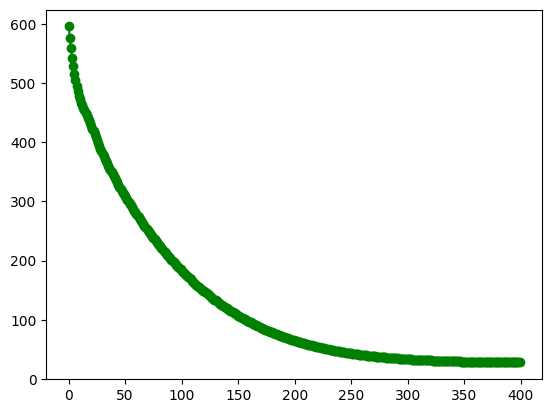

In [372]:
w_history, cost_history = gradient_descent_linear(linear_regression_cost, x_standard,\
                                                  y, lamb=150, alpha=1e-1, iterations=400)
plt.plot(cost_history, "go-")

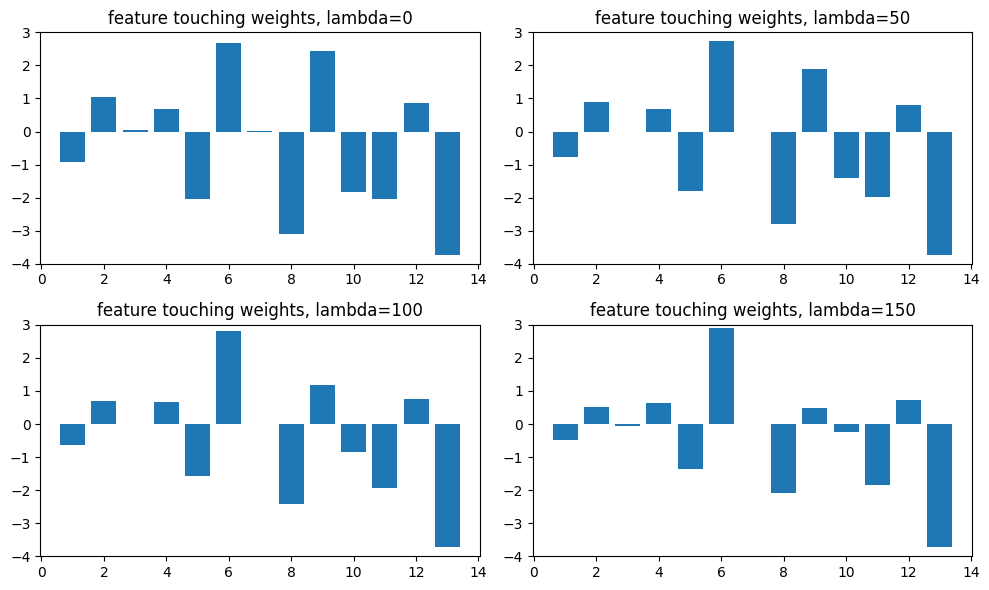

In [374]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
for axi, w in zip(ax.flatten(), w_arr):
    axi.bar(np.arange(1,14,1), np.array(w[-1][1:]).flatten(),  label=f"lambda={w[0]}")
    axi.set_title(f"feature touching weights, lambda={w[0]}")
    axi.set_ylim([-4, 3])
plt.tight_layout()
plt.show()